In [1]:
LABEL = 'Main1'

### Imports

In [2]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import os
import time
import random
import pickle

In [4]:
import datetime as datetime

In [5]:
from IPython.display import display
from collections import Counter

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 8)

In [7]:
pd.options.display.max_columns = 500 

In [8]:
train = pd.read_csv('NIJ_s_Recidivism_Challenge_Training_Dataset.csv', index_col = 'ID')
train.head()

,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,Prison_Offense,Prison_Years,Prior_Arrest_Episodes_Felony,Prior_Arrest_Episodes_Misd,Prior_Arrest_Episodes_Violent,Prior_Arrest_Episodes_Property,Prior_Arrest_Episodes_Drug,Prior_Arrest_Episodes_PPViolationCharges,Prior_Arrest_Episodes_DVCharges,Prior_Arrest_Episodes_GunCharges,Prior_Conviction_Episodes_Felony,Prior_Conviction_Episodes_Misd,Prior_Conviction_Episodes_Viol,Prior_Conviction_Episodes_Prop,Prior_Conviction_Episodes_Drug,Prior_Conviction_Episodes_PPViolationCharges,Prior_Conviction_Episodes_DomesticViolenceCharges,Prior_Conviction_Episodes_GunCharges,Prior_Revocations_Parole,Prior_Revocations_Probation,Condition_MH_SA,Condition_Cog_Ed,Condition_Other,Violations_ElectronicMonitoring,Violations_Instruction,Violations_FailToReport,Violations_MoveWithoutPermission,Delinquency_Reports,Program_Attendances,Program_UnexcusedAbsences,Residence_Changes,Avg_Days_per_DrugTest,DrugTests_THC_Positive,DrugTests_Cocaine_Positive,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,M,BLACK,43-47,16,False,3.0,Standard,At least some college,3 or more,Drug,More than 3 years,6,6 or more,1,3,3,4,False,False,3 or more,3,False,2,2 or more,False,False,False,False,False,True,True,False,False,False,False,False,0,6,0,2,612.000000,0.000000,0.0,0.000000,0.0,0.488562,0.447610,False,False,False,False,False
2,M,BLACK,33-37,16,False,6.0,Specialized,Less than HS diploma,1,Violent/Non-Sex,More than 3 years,7,6 or more,3 or more,0,3,5 or more,True,False,3 or more,4 or more,True,0,2 or more,True,True,True,False,False,False,False,False,False,True,False,False,4 or more,0,0,2,35.666667,0.000000,0.0,0.000000,0.0,0.425234,2.000000,False,True,False,False,True
3,M,BLACK,48 or older,24,False,7.0,High,At least some college,3 or more,Drug,1-2 years,6,6 or more,3 or more,2,2,5 or more,True,False,3 or more,2,True,1,2 or more,False,True,False,False,False,True,True,False,False,True,False,True,4 or more,6,0,0,93.666667,0.333333,0.0,0.166667,0.0,0.000000,0.000000,False,True,False,True,False
4,M,WHITE,38-42,16,False,7.0,High,Less than HS diploma,1,Property,1-2 years,8,6 or more,0,3,3,3,False,False,3 or more,4 or more,False,3 or more,2 or more,False,False,False,False,True,True,True,False,False,False,False,False,0,6,0,3 or more,25.400000,0.000000,0.0,0.000000,0.0,1.000000,0.718996,False,False,False,False,False
5,M,WHITE,33-37,16,False,4.0,Specialized,Less than HS diploma,3 or more,Violent/Non-Sex,1-2 years,4,4,3 or more,2,1,3,True,False,1,0,True,0,1,False,False,False,False,False,True,True,True,False,False,False,False,0,7,0,0,23.117647,0.000000,0.0,0.058824,0.0,0.203562,0.929389,False,True,True,False,False


In [13]:
test = pd.read_csv('NIJ_s_Recidivism_Challenge_Test_Dataset1.csv', index_col = 'ID')
test.head()

,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,Prison_Offense,Prison_Years,Prior_Arrest_Episodes_Felony,Prior_Arrest_Episodes_Misd,Prior_Arrest_Episodes_Violent,Prior_Arrest_Episodes_Property,Prior_Arrest_Episodes_Drug,Prior_Arrest_Episodes_PPViolationCharges,Prior_Arrest_Episodes_DVCharges,Prior_Arrest_Episodes_GunCharges,Prior_Conviction_Episodes_Felony,Prior_Conviction_Episodes_Misd,Prior_Conviction_Episodes_Viol,Prior_Conviction_Episodes_Prop,Prior_Conviction_Episodes_Drug,Prior_Conviction_Episodes_PPViolationCharges,Prior_Conviction_Episodes_DomesticViolenceCharges,Prior_Conviction_Episodes_GunCharges,Prior_Revocations_Parole,Prior_Revocations_Probation,Condition_MH_SA,Condition_Cog_Ed,Condition_Other
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,M,WHITE,38-42,17,False,5.0,Standard,High School Diploma,0,Property,More than 3 years,4,0,1,3,0,0,False,False,1,0,False,2,0,False,False,False,False,False,False,False,True
8,M,BLACK,38-42,16,False,5.0,High,High School Diploma,3 or more,Drug,Greater than 2 to 3 years,6,6 or more,3 or more,1,2,5 or more,False,False,1,4 or more,True,0,2 or more,True,False,False,False,False,False,True,False
12,M,BLACK,33-37,16,False,5.0,Specialized,High School Diploma,3 or more,Other,1-2 years,10 or more,1,1,1,2,3,False,False,3 or more,1,False,0,2 or more,False,False,False,False,True,True,True,True
15,M,WHITE,33-37,5,False,7.0,Standard,Less than HS diploma,1,Violent/Non-Sex,Greater than 2 to 3 years,9,3,2,2,4,4,False,True,3 or more,2,True,1,1,True,False,False,False,False,True,True,True
16,M,BLACK,33-37,3,False,4.0,Standard,Less than HS diploma,3 or more,NaN,More than 3 years,4,6 or more,0,0,3,4,False,True,2,4 or more,False,0,2 or more,True,False,False,False,False,True,True,False


In [14]:
test.shape

(7807, 32)

In [15]:
x = pd.concat((train[test.columns], test)).sort_index()

### Regional Features

In [16]:
puma_rows = dict(Counter(x.Residence_PUMA))

In [17]:
puma = pd.read_csv('PUMA.txt', delimiter = '\t', index_col = 'Code').iloc[:, 0]
puma_ct = puma.str.split(', ').apply(lambda x: len(x)).to_dict()

In [18]:
puma_name = pd.read_csv('puma_info.csv', index_col = 'Code').iloc[:, 0]
puma_name.index = puma_name.index.to_series().apply(lambda x: int(x.split(' ')[1]))

In [19]:
s_groups = {}
for s in ['Atlanta', 'Central', 'Coastal', 'Georgia Mountains', 'Heart of Georgia', 'Middle Georgia',
                 'Northeast Georgia', 'Northwest Georgia', 'River Valley', 'Southern Georgia',
                         'Southwest Georgia', 'Three Rivers' ]:
    s_groups['pums_' + s] = puma_name.str.startswith(s)

In [20]:
puma_regions = []
for s_group, sga in s_groups.items():
    puma_regions.append((s_group, puma.apply(lambda x: np.mean([sga.loc[int(c)] for c in x.split(', ')]))) )

In [21]:
puma_region_df = pd.DataFrame(dict(puma_regions))
puma_region_df.sum()[:5]

pums_Atlanta              10.714286
pums_Central               1.000000
pums_Coastal               1.666667
pums_Georgia Mountains     0.785714
pums_Heart of Georgia      1.000000
dtype: float64

In [22]:
def pumaMap(df, x):
    region_df = df.loc[x.Residence_PUMA]
    region_df = pd.DataFrame(region_df.values, index = x.index, columns = region_df.columns)
    return region_df

In [23]:
region_df = pumaMap(puma_region_df, x)

In [24]:
puma_df = pd.concat( ( region_df,
                          pd.DataFrame( {'puma_ct': x.Residence_PUMA.map(puma_ct), 
                                             'puma_rows':  x.Residence_PUMA.map(puma_rows ) } ) ), axis = 1)

puma_df.shape

(25835, 14)

### Modeling

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold, ShuffleSplit
from sklearn.metrics import brier_score_loss, mean_squared_error, log_loss, make_scorer

In [26]:
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Ridge, ElasticNet, LogisticRegression, RidgeClassifier, MultiTaskElasticNet
from sklearn.svm import SVR, SVC, LinearSVR, LinearSVC, NuSVC, NuSVR
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [27]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler


In [28]:
import lightgbm as lgb

In [29]:
def boundedMSE(y_true, y_pred):
    residual = ( y_pred * (1 - BOUND) + y_pred.clip(0, 1) * BOUND)  - y_true
    return 2 * residual, 2 * np.ones(len(y_true))

In [30]:
y = train['Recidivism_Arrest_Year1']

In [31]:
ys = train[['Recidivism_Within_3years', 'Recidivism_Arrest_Year2', 	'Recidivism_Arrest_Year3',
                   'Recidivism_Arrest_Year1']]

In [32]:
extra = train[set(train.columns) - set(test.columns) - set(ys.columns)]

### Feature Encoding

In [33]:
def more(x):
    for col in [c for c in x.columns if x[c].dtype == 'object' or x[c].dtype.name == 'category' ]:
        ctr = Counter(x[col])
        if len( omk := [k for k in ctr.keys() if hasattr(k, '__iter__') 
                            and ' or more' in k]) == 1:

            x[col] = x[col].astype(str)
            x.loc[x[col] == omk[0], col] = int(omk[0].split(' ')[0])
            x[col] = x[col].astype(int)
    return x

In [34]:
all_targets = train[set(train.columns) - set(test.columns)].copy()
all_targets = more(all_targets)

In [35]:
def labelDJ(x):
    for col in [c for c in x.columns if 'DrugTest' in c or 'Percent_' in c or 'Per_' in c]:
        print(col)
        x[col + '_nan'] = x[col].isnull()    
        x[col + '_nonzero'] = x[col] > 0

        if 'DrugTests' in col:
            pass;
        else:
            x[col + '_1'] = x[col] == 1

        if col == 'Jobs_Per_Year':
            x[col + '_whole'] = x[col].fillna(0.5) == x[col].fillna(5.5).astype(int)
    
    return x

In [36]:
all_targets = labelDJ(all_targets)

Jobs_Per_Year
DrugTests_THC_Positive
DrugTests_Other_Positive
Avg_Days_per_DrugTest
Percent_Days_Employed
DrugTests_Cocaine_Positive
DrugTests_Meth_Positive


In [37]:
plt.rcParams['figure.max_open_warning'] = 100

In [38]:
all_targets.to_csv('all_targets.csv')

In [39]:
all_targets.head()

,Jobs_Per_Year,Program_UnexcusedAbsences,DrugTests_THC_Positive,Violations_MoveWithoutPermission,DrugTests_Other_Positive,Employment_Exempt,Recidivism_Within_3years,Avg_Days_per_DrugTest,Residence_Changes,Violations_ElectronicMonitoring,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Delinquency_Reports,Percent_Days_Employed,Violations_Instruction,Program_Attendances,Violations_FailToReport,DrugTests_Cocaine_Positive,DrugTests_Meth_Positive,Recidivism_Arrest_Year3,Jobs_Per_Year_nan,Jobs_Per_Year_nonzero,Jobs_Per_Year_1,Jobs_Per_Year_whole,DrugTests_THC_Positive_nan,DrugTests_THC_Positive_nonzero,DrugTests_Other_Positive_nan,DrugTests_Other_Positive_nonzero,Avg_Days_per_DrugTest_nan,Avg_Days_per_DrugTest_nonzero,Avg_Days_per_DrugTest_1,Percent_Days_Employed_nan,Percent_Days_Employed_nonzero,Percent_Days_Employed_1,DrugTests_Cocaine_Positive_nan,DrugTests_Cocaine_Positive_nonzero,DrugTests_Meth_Positive_nan,DrugTests_Meth_Positive_nonzero
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.447610,0,0.000000,False,0.0,False,False,612.000000,2,False,False,False,0,0.488562,False,6,False,0.0,0.000000,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
2,2.000000,0,0.000000,False,0.0,False,True,35.666667,2,False,False,False,4,0.425234,True,0,False,0.0,0.000000,True,False,True,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False
3,0.000000,0,0.333333,True,0.0,False,True,93.666667,0,False,False,True,4,0.000000,True,6,False,0.0,0.166667,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True
4,0.718996,0,0.000000,False,0.0,False,False,25.400000,3,False,False,False,0,1.000000,False,6,False,0.0,0.000000,False,False,True,False,False,False,False,False,False,False,True,False,False,True,True,False,False,False,False
5,0.929389,0,0.000000,False,0.0,False,True,23.117647,0,False,True,False,0,0.203562,False,7,False,0.0,0.058824,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True


In [40]:
maps = {'Education_Level': dict([('High School Diploma', 1), 
                                      ('Less than HS diploma', 0), 
                                          ('At least some college', 2)]),
        'Prison_Years': dict([('1-2 years', 1.5), 
                              ('Less than 1 year', 0.7), 
                              ('More than 3 years', 3.8), 
                              ('Greater than 2 to 3 years', 2.5)]),
       }
        


In [41]:
def featurize(x):
    x = x.copy()
    ncols = x.shape[1]
    # or more -> numerical; age at release -> numerical; mapping of educaiton and prison time
    for col in [c for c in x.columns if x[c].dtype == 'object' or x[c].dtype.name == 'category' ]:
        ctr = Counter(x[col])
        if len( omk := [k for k in ctr.keys() if hasattr(k, '__iter__') 
                            and ' or more' in k]) == 1:

            x[col] = x[col].astype(str)
            x.loc[x[col] == omk[0], col] = int(omk[0].split(' ')[0])
            x[col] = x[col].astype(int)
        elif col == 'Age_at_Release':
            x[col] = x[col].str.replace(' ', '-').str.split('-').apply(lambda x: x[0]).astype(int)
        elif col in maps.keys():
            x[col] = x[col].map( maps[col] )
            x[col] = pd.Categorical(x[col])

        else:
            x[col] = pd.Categorical(x[col])
            print(col)
            print(Counter(x[col]).most_common())

    # custom features
    x['Violent'] = x['Prison_Offense'].str.contains('Violent').fillna(-1).astype(int)

    for cset in ['Condition_', 'Revocations_', 'Prior_Conviction_', 'Prior_Arrest_']:             
        x[cset + 'count'] = x[[c for c in x.columns if cset in c]].fillna(0).sum(axis = 1)
        
    x['num_property_crimes'] = ( x[[c for c in x.columns if '_Prop' in c]].sum(axis = 1) 
                                + ( x['Prison_Offense'] == 'Property' ) )

    ppv =  ['Prior_Conviction_Episodes_PPViolationCharges', 'Prior_Revocations_Parole', 'Prior_Revocations_Probation']
    x['sum_ppv'] = x[ppv].sum(axis = 1)
    x['any_ppv'] = x[ppv].any(axis = 1)
        
    return x, x.columns[ncols:]


In [42]:
x, new_cols = featurize(x)

Gender
[('M', 22668), ('F', 3167)]
Race
[('BLACK', 14847), ('WHITE', 10988)]
Gang_Affiliated
[(False, 18730), (True, 3938), (nan, 3167)]
Supervision_Level_First
[('Standard', 9983), ('Specialized', 7123), ('High', 7009), (nan, 1720)]
Prison_Offense
[('Property', 8284), ('Violent/Non-Sex', 5475), ('Drug', 5190), (nan, 3277), ('Other', 2779), ('Violent/Sex', 830)]


### One-Hot Encoding

In [43]:
xe = x.copy()

In [44]:
xe['Supervision_Risk_Score_First'].fillna(xe['Supervision_Risk_Score_First'].mean(), inplace = True)

In [45]:
for col in (cb_cols := [c for c in x.columns if x[c].dtype.name == 'category' or x[c].dtype == 'object'
                        or x[c].dtype == 'bool' and c != 'Violent'] 
                    + ['Age_at_Release', 'Residence_PUMA', 'Dependents']):
    xe[col] = xe[col].astype(str).fillna('nan')
#     print(col, '-', Counter(xe[col]))
    

In [46]:
xe.head()

,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,Prison_Offense,Prison_Years,Prior_Arrest_Episodes_Felony,Prior_Arrest_Episodes_Misd,Prior_Arrest_Episodes_Violent,Prior_Arrest_Episodes_Property,Prior_Arrest_Episodes_Drug,Prior_Arrest_Episodes_PPViolationCharges,Prior_Arrest_Episodes_DVCharges,Prior_Arrest_Episodes_GunCharges,Prior_Conviction_Episodes_Felony,Prior_Conviction_Episodes_Misd,Prior_Conviction_Episodes_Viol,Prior_Conviction_Episodes_Prop,Prior_Conviction_Episodes_Drug,Prior_Conviction_Episodes_PPViolationCharges,Prior_Conviction_Episodes_DomesticViolenceCharges,Prior_Conviction_Episodes_GunCharges,Prior_Revocations_Parole,Prior_Revocations_Probation,Condition_MH_SA,Condition_Cog_Ed,Condition_Other,Violent,Condition_count,Revocations_count,Prior_Conviction_count,Prior_Arrest_count,num_property_crimes,sum_ppv,any_ppv
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,M,BLACK,43,16,False,3.0,Standard,2,3,Drug,3.8,6,6,1,3,3,4,False,False,3,3,False,2,2,False,False,False,False,False,True,True,False,0,2,0,10.0,23.0,5,0,False
2,M,BLACK,33,16,False,6.0,Specialized,0,1,Violent/Non-Sex,3.8,7,6,3,0,3,5,True,False,3,4,True,0,2,True,True,True,False,False,False,False,False,1,0,0,13.0,25.0,0,1,True
3,M,BLACK,48,24,False,7.0,High,2,3,Drug,1.5,6,6,3,2,2,5,True,False,3,2,True,1,2,False,True,False,False,False,True,True,False,0,2,0,10.0,25.0,3,0,False
4,M,WHITE,38,16,False,7.0,High,0,1,Property,1.5,8,6,0,3,3,3,False,False,3,4,False,3,2,False,False,False,False,True,True,True,False,0,2,1,12.0,23.0,7,1,True
5,M,WHITE,33,16,False,4.0,Specialized,0,3,Violent/Non-Sex,1.5,4,4,3,2,1,3,True,False,1,0,True,0,1,False,False,False,False,False,True,True,True,1,3,0,3.0,18.0,2,0,False


In [47]:
ohe = OneHotEncoder( drop = 'first')
scat_df = pd.DataFrame( ohe.fit_transform(xe[cb_cols].astype(str).fillna('nan')).todense(),
                     index = xe.index, columns = ohe.get_feature_names(cb_cols) )
xess = pd.concat((scat_df, xe[[c for c in xe.columns if c not in cb_cols]]), axis = 1 )

In [48]:
ohe = OneHotEncoder()
cat_df = pd.DataFrame( ohe.fit_transform(xe[cb_cols].astype(str).fillna('nan')).todense(),
                     index = xe.index, columns = ohe.get_feature_names(cb_cols) )
xe = pd.concat((cat_df, xe[[c for c in xe.columns if c not in cb_cols]]), axis = 1 )


In [49]:
xe.shape

(25835, 102)

In [50]:
xess.shape

(25835, 80)

In [51]:
xe.to_csv('xe.csv')

### Interpolation Features

In [52]:
def singleFold(x, y, quant, model, params, n_iter, scoring, cv = 5, verbose = 0):

    scores = []; y_preds = []; models = []
    start = time.time()
    iy_preds = []    

    for ir_idx in range(INTERPOLATION_REPEATS):
        clf = RandomizedSearchCV(model, params, n_iter = n_iter, 
                                 scoring = scoring, n_jobs = min(16, os.cpu_count()),
                                  cv = ( StratifiedKFold(shuffle = True, 
                                                     n_splits = cv,
                         random_state = datetime.datetime.now().microsecond) if not quant
                                                else KFold(shuffle = True, 
                                                        n_splits = cv,
                                                        random_state = datetime.datetime.now().microsecond) ))
        xc = x[~y.isnull()]; yc = y.reindex(xc.index)
        if not quant: yc = yc.astype('category')
        yc = yc if quant else pd.Series( LabelEncoder().fit_transform(yc), index = yc.index)

        
        clf.fit(xc, yc)
        models.append(model := clf.best_estimator_)
        y_pred = ( (model.decision_function if hasattr(model, 'decision_function') else
                            (model.predict_proba if hasattr(model, 'predict_proba') else model.predict) )
                                                (x) )
        y_pred = y_pred[:, -1] if len(y_pred.shape) == 2 and y_pred.shape[1] == 2 else y_pred
        iy_preds.append(y_pred)

    y_pred = pd.DataFrame(np.array(iy_preds).mean(axis = 0), index = x.index ) 

    print(yc)
    print(y_pred.reindex(yc.index))
    metric = (mean_squared_error if 'mean_squared_error' in scoring else log_loss)
    scores.append( score := metric(yc #if len(y.shape) == 1 else yc.iloc[:, -1]
                                   , y_pred.reindex(yc.index)  ) )

    print('{:.4f}'.format(score))

#     print(' average: {:.4f}'.format(  np.mean(scores)) )

    if verbose >= 3:
        print(models)
                
    return models, scores, y_pred

In [53]:
import seaborn as sns

In [54]:
lgb_params = {
    'n_estimators': [300, 400, 500],
    'num_leaves': [ 7, 10, 14, 20, 20, 30, 50],
    'learning_rate': [0.01, 0.014, 0.02, 0.03, 0.03, 0.04, 0.05, 0.07,  ],
    'min_child_weight': [1e-4, 3e-4, 1e-3, 3e-3, 0.01, 0.02, 0.05, 0.1,],
    'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 1],
    'colsample_bynode': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 1],
    'reg_alpha': [0, 1e-5, 1e-3, 1e-2, 0.1, 1,],
    'reg_lambda': [1e-5, 1e-3, 1e-2, 0.1, 1, 10, 100, 1000],
    'subsample': [ 0.9, 0.95, 0.98, 1],
    'subsample_freq': [1],
    
}

In [55]:
INTERPOLATION_REPEATS = 4

In [56]:
%%time
pred_cols =  ['Gang_Affiliated', 'Gang_Affiliated', 
                      'Age_at_Release', 'Supervision_Risk_Score_First', 
                              'Prison_Years', 'Prison_Years']

pmodels, pscores, ppreds = {}, {}, {}
for pred_col in pred_cols:
    print(pred_col)
    xc, yc = x.drop(columns = pred_col), x[pred_col]
    
    repeat = pred_col in ppreds.keys()
    yc = yc.astype('float') if repeat else yc
    name = pred_col + '_linear' if repeat else pred_col

    pmodels[name], pscores[name], ppreds[name] = \
                singleFold(xc, yc, quant := yc.dtype in ['float', 'int'], 
                 lgb.LGBMRegressor(n_jobs = 1) if quant else lgb.LGBMClassifier(n_jobs = 1),
                        lgb_params, 6,  ('neg_mean_squared_error' if quant else 'neg_log_loss'), 
                          verbose = 5)
    print()

Gang_Affiliated
ID
1        0
2        0
3        0
4        0
5        0
        ..
26755    0
26756    0
26758    0
26759    0
26761    0
Length: 22668, dtype: int64
              0
ID             
1      0.029749
2      0.148889
3      0.019439
4      0.082048
5      0.096586
...         ...
26755  0.033304
26756  0.132219
26758  0.023578
26759  0.033455
26761  0.125375

[22668 rows x 1 columns]
0.3581
[LGBMClassifier(colsample_bynode=0.98, colsample_bytree=0.8, learning_rate=0.03,
               min_child_weight=0.0003, n_estimators=400, n_jobs=1,
               num_leaves=10, reg_alpha=1e-05, reg_lambda=100, subsample=0.98,
               subsample_freq=1), LGBMClassifier(colsample_bynode=0.6, colsample_bytree=0.4, learning_rate=0.02,
               n_estimators=500, n_jobs=1, num_leaves=20, reg_alpha=1,
               reg_lambda=0.01, subsample=0.98, subsample_freq=1), LGBMClassifier(colsample_bynode=0.7, colsample_bytree=0.4, learning_rate=0.02,
               n_estimators=500, 

In [57]:
ridge_params = {
    'alpha': [1e-2, 0.1, 1, 2, 5, 10, 20, 50, 100, 300, 1000],
    'fit_intercept': [False],
    'normalize': [True, False],   
}

In [58]:
pred_cols =  ['Gang_Affiliated',
                      'Age_at_Release', 'Supervision_Risk_Score_First', 
                              'Prison_Years',  ]

for pred_col in pred_cols:
    print(pred_col)
    xc, yc = xe.drop(columns = [c for c in xe.columns if c.startswith(pred_col)]), x[pred_col]    
    yc = yc.astype('float') 
    name = pred_col + '_ridge'

    pmodels[name], pscores[name], ppreds[name] = \
                singleFold(xc, yc,  True,
                           Ridge(),
                        ridge_params, 5,  'neg_mean_squared_error', 
                          verbose = 5)
    print()

Gang_Affiliated
ID
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
        ... 
26755    0.0
26756    0.0
26758    0.0
26759    0.0
26761    0.0
Name: Gang_Affiliated, Length: 22668, dtype: float64
              0
ID             
1      0.059389
2      0.191615
3      0.007919
4      0.069282
5      0.175883
...         ...
26755  0.052429
26756  0.261275
26758 -0.009331
26759  0.064160
26761  0.173498

[22668 rows x 1 columns]
0.1229
[Ridge(alpha=20, fit_intercept=False, normalize=True), Ridge(alpha=5, fit_intercept=False, normalize=True), Ridge(alpha=5, fit_intercept=False, normalize=True), Ridge(alpha=50, fit_intercept=False, normalize=True)]

Age_at_Release
ID
1        43.0
2        33.0
3        48.0
4        38.0
5        33.0
         ... 
26756    23.0
26758    38.0
26759    33.0
26760    33.0
26761    28.0
Name: Age_at_Release, Length: 25835, dtype: float64
               0
ID              
1      45.086897
2      36.054149
3      33.918400
4      33.925539
5 

In [59]:
x = x.drop(columns = (dc := [c for c in x.columns if '_pred' in c]) )
xe = xe.drop(columns = (dc := [c for c in xe.columns if '_pred' in c]) )
xess = xess.drop(columns = (dc := [c for c in xess.columns if '_pred' in c]) )

In [60]:
def addPreds(df):
    for pred_col in ppreds.keys():
        df = pd.concat((df, pd.DataFrame( pp := ppreds[pred_col].reindex(df.index).values, 
                                           index = df.index,
                                        columns = ( [pred_col + '_pred'] if pp.shape[1] == 1 
                                                     else  ['{}_{}_{}'.format(pred_col, c, 'pred')
                                                                    for c in x[pred_col].dtype.categories] )

                                      )), axis = 1)
    return df

In [61]:
x = addPreds(x)
xe = addPreds(xe)
xess = addPreds(xess)

In [62]:
# x.head()

In [56]:
# xess.head()

In [63]:
filled_cols = []
for pred_col in [c for c in pred_cols if x[c].isnull().sum() > 0]:
    if ppreds[pred_col].columns > 1: print('{} multi-column'.format(pred_col)); continue;
    print(pred_col)
    x[pred_col + '_predfill'] = x[pred_col].astype(float).fillna(ppreds[pred_col][0].reindex(x.index))
    filled_cols.append(pred_col)

Gang_Affiliated
Supervision_Risk_Score_First


In [64]:
filled_cols = []
for pred_col in [c for c in pred_cols if x[c].isnull().sum() > 0]:
    for df in [xe, xess]:
        if ppreds[pred_col].columns > 1: print('{} multi-column'.format(pred_col)); continue;
        print(pred_col)
        xe_col = pred_col + '_True' if pred_col not in df.columns else pred_col
        df[pred_col + '_predfill'] = df[xe_col].astype(float).fillna(ppreds[pred_col][0].reindex(x.index))
        filled_cols.append(pred_col)

Gang_Affiliated
Gang_Affiliated
Supervision_Risk_Score_First
Supervision_Risk_Score_First


In [65]:
from joblib import Parallel, delayed
import math
from collections import defaultdict

In [66]:
NJI = 1 # os.cpu_count() // 16
NJI

1

In [67]:
x.isnull().sum().sort_values()[::-1][:10]

Prison_Offense                                  3277
Gang_Affiliated                                 3167
Supervision_Level_First                         1720
Supervision_Risk_Score_First                     475
Supervision_Risk_Score_First_predfill              0
Prior_Arrest_Episodes_Drug                         0
Prior_Conviction_Episodes_PPViolationCharges       0
Prior_Conviction_Episodes_Drug                     0
Prior_Conviction_Episodes_Prop                     0
Prior_Conviction_Episodes_Viol                     0
dtype: int64

### Model Fit Wrapper

In [68]:
N_REPEATS = 25
N_INTERNAL_REPEATS = 1

In [69]:
def norm(x, all_indices, scaler = StandardScaler):
    fs = scaler().fit(x.loc[all_indices[0]])
    dfs = []
    for indices in all_indices:
        xs = x.loc[indices]
        dfs.append( pd.DataFrame( fs.transform(xs), index = xs.index, columns = xs.columns))
    return dfs

In [70]:
def fitModel(x, y, model, params, n_iter, scoring, cv,  feature_drop = 0.1,
             scaler = FunctionTransformer,
             extra_drops = {},
                 verbose = -1):
    global BOUND
    scores = []; y_preds = []; models = []; test_preds = []
    start = time.time()
    for fold_idx, fold in enumerate(folds[:N_REPEATS * 5]):
        train_indices = y.iloc[fold[0]].index
        holdout_indices = y.iloc[fold[1]].index
        test_indices = set(x.index) - set(y.index)

        iy_preds = []; iy_test_preds = []
        for ir_idx in range(N_INTERNAL_REPEATS):
            drop_cols = random.choices(x.columns, 
                                k = int(random.random() * feature_drop * len(x.columns)))
            BOUND = random.random() * 1.0 + 0.0
            clf = RandomizedSearchCV(model, params, n_iter = n_iter, 
                                     scoring = scoring, n_jobs = -1, cv = cv)
            
            all_drops = drop_cols
            for substrs, prob in extra_drops.items():
                if random.random() < prob:
                    print(substrs)
                    all_drops.extend([c for c in x.columns 
                                       if all([c.count(z) == 1 for z in substrs])])
                    
#             print(all_drops)
            xd = x.drop(columns = all_drops)
            if 'ID' in xd.columns:
                xd = xd.copy()
                xd['ID'] += np.random.normal(0, 20, len(xd))
#                 print(xd['ID'])
            
            
            x_train, x_holdout, x_test = norm(xd, 
                                              (train_indices, holdout_indices, test_indices), 
                                                  scaler)

            y_train = y.loc[train_indices]
            clf.fit(x_train, y_train)

            models.append(model := clf.best_estimator_)
            if verbose >= 5: print(model)
                
            # out of fold
            y_pred = ( (model.predict_proba if hasattr(model, 'predict_proba') else model.predict) 
                             (x_holdout)  ).clip(0, 1)
            y_pred = y_pred[:, -1] if len(y_pred.shape) == 2  else y_pred
#             print(y_pred.head())
            iy_preds.append(y_pred)
            
            # test
            y_pred = ( (model.predict_proba if hasattr(model, 'predict_proba') else model.predict) 
                             (x_test  ) ).clip(0, 1)
            y_pred = y_pred[:, -1] if len(y_pred.shape) == 2  else y_pred
#             print(y_pred.head())
            iy_test_preds.append(y_pred)
            
        
        y_pred = np.array(iy_preds).mean(axis = 0)
        y_pred_test = np.array(iy_test_preds).mean(axis = 0)
        
        metric = mean_squared_error if 'mean_squared_error' in scoring else log_loss
        scores.append( score := metric(y.iloc[fold[1]] if len(y.shape) == 1 
                                                                       else y.iloc[fold[1], -1], 
                                  y_pred  ) )
        y_preds.append( pd.Series(y_pred, index = holdout_indices ) )
        test_preds.append( pd.Series(y_pred_test, index = test_indices ) )
            
        if verbose >= 0: print('{:.4f}'.format(score))

        if (fold_idx + 1) % 5 == 0:
            print('Running average after {} repeats: {:.4f}'.format( fold_idx // 5 + 1, np.mean(scores)) )
            yp = pd.concat(y_preds).clip(0, 1)
            print('Blended average after {} repeats: {:.5f}'.format( fold_idx // 5 + 1, 
                        final_score_1 := metric( y, 
                                    yp.groupby(yp.index).mean().reindex(y.index).clip(0, 1)) ) )
            print('Blended median  after {} repeats: {:.5f}'.format( fold_idx // 5 + 1, 
                        final_score_2 := metric( y, 
                                    yp.groupby(yp.index).median().reindex(y.index).clip(0, 1) ) ) )
            print('{:.1f}s'.format(time.time() - start))
            print()
        
            if verbose >= 3: print(models[-5:])
                
    return ( {'models': models, 'scores': scores, 'y_preds': y_preds, 'test_preds': test_preds}, 
                    min(final_score_1, final_score_2) )

In [71]:
%%time
fold_seed = 5306
folds = []; 
for i in range(1000):
    folds.extend(list(StratifiedKFold(random_state = i + fold_seed, shuffle = True)
                              .split(np.zeros(len(y)), y)))

CPU times: user 2.67 s, sys: 255 ms, total: 2.92 s
Wall time: 2.92 s


In [72]:
N_REPEATS = 25


### Actually Run Models

In [74]:
try:
    os.mkdir('results')
except:
    pass;

In [75]:
# N_REPEATS = 50

In [76]:
# ridge_params = {
#     'alpha': [1e-2, 0.1, 0.3, 1, 2, 5, 10, 20, 50, 100, 300, 1000],
#     'fit_intercept': [False, True],
# }


# model = 'Ridge'
# r, final_score = fitModel(  pd.concat((xe, puma_df, #pumaMap(hfs, x), pumaMap(pfs, x),
#                                        xe.index.to_series(),
#                                               ), axis = 1), 
#                                                      y, Ridge(), ridge_params,  n_iter = 6,
#                      scoring = 'neg_mean_squared_error',  cv = StratifiedKFold(n_splits = 5, shuffle = True,
#                                                         random_state = datetime.datetime.now().microsecond),
#                             feature_drop = 0.2,   scaler = StandardScaler,
#                     )
# pickle.dump(r, open('results/{}_{}_{}*{}_{}.pkl'.format(
#                     LABEL, model, fold_seed, N_REPEATS, round(final_score, 4)), 'wb') )

In [97]:
lgbr_params = {
    'n_estimators': [300, 400, 500, 600],
    'num_leaves': [ 5, 7, 10, 14, 20, ],
    'learning_rate': [ 0.01, 0.014, 0.02, 0.03, 0.03, 0.04, 0.05, 0.07,  ],
    'min_child_weight': [1e-4, 3e-4, 1e-3, 3e-3, 0.01, 0.02, 0.05, 0.1, ],
    'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 1],
    'colsample_bynode': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 1],
    'reg_alpha': [ 1e-5, 1e-3, 1e-2, 0.1, 1, 10, ],
    'reg_lambda': [ 1e-3, 1e-2, 0.1, 1, 10, 100, ],
    'subsample': [ 0.9, 0.95, 0.98, 1],
    'subsample_freq': [1, ], #5, ],
}

In [98]:
N_REPEATS = 20

In [100]:
%%time
model = 'LGBR'
r, final_score = fitModel(pd.concat( ( x[test.columns], 
                                      x.index.to_series(), 
                                      puma_df,
                                     
                                     ), axis = 1 ), 
                         y, lgb.LGBMRegressor(objective = boundedMSE, n_jobs = 1), 
                                                  lgbr_params, 8, 
                     'neg_mean_squared_error', StratifiedKFold(n_splits = random.randrange(5, 7), shuffle = True,
                                                            random_state = datetime.datetime.now().microsecond),
                                                 verbose = 3,# feature_drop = 0.1
                                                 )
pickle.dump(r, open('results/{}_{}_{}*{}_{}.pkl'.format(
                    LABEL, model, fold_seed, N_REPEATS, round(final_score, 4)), 'wb') )

0.1862
0.1856
0.1864
0.1897
0.1878
Running average after 1 repeats: 0.1872
Blended average after 1 repeats: 0.18717
Blended median  after 1 repeats: 0.18717
23.3s

[LGBMRegressor(colsample_bynode=0.7, colsample_bytree=0.3, learning_rate=0.02,
              min_child_weight=0.003, n_estimators=600, n_jobs=1, num_leaves=7,
              objective=<function boundedMSE at 0x7f2e66ff2310>, reg_alpha=10,
              reg_lambda=10, subsample=1, subsample_freq=1), LGBMRegressor(colsample_bynode=0.9, colsample_bytree=0.8, learning_rate=0.02,
              min_child_weight=0.0001, n_estimators=600, n_jobs=1, num_leaves=5,
              objective=<function boundedMSE at 0x7f2e66ff2310>,
              reg_alpha=0.001, reg_lambda=100, subsample=0.98,
              subsample_freq=1), LGBMRegressor(colsample_bynode=0.4, colsample_bytree=1, learning_rate=0.02,
              min_child_weight=0.1, n_estimators=400, n_jobs=1, num_leaves=14,
              objective=<function boundedMSE at 0x7f2e66ff2310

### Multi-Layer Models

In [101]:
N_REPEATS = 10

In [102]:
x_original = x[test.columns]


In [103]:
bool_targets = sorted([c for c in all_targets.columns if all_targets[c].dtype == 'bool'])
regr_targets = sorted([c for c in all_targets.columns if all_targets[c].dtype != 'bool'])

In [105]:
try:
    os.mkdir('main_layer1_other_targets')
except:
    pass;

In [106]:
for target in regr_targets:
    model = 'LGBR_OT_{}'.format(target); print(model)
    r, final_score = fitModel(pd.concat( ( x_original,
                                          x_original.index.to_series(), 
                                         ), axis = 1 ), 
                             all_targets[target].fillna(0), 
                                  lgb.LGBMRegressor(objective = boundedMSE, n_jobs = 1), 
                                                      lgbr_params, 8, 
                         'neg_mean_squared_error',  #Stratified 
                                      KFold(n_splits = random.randrange(5, 7), 
                                                                   shuffle = True,
                                                random_state = datetime.datetime.now().microsecond),
                                                     verbose = 3,# feature_drop = 0.1
                                                     )
    pickle.dump(r, open('main_layer1_other_targets/{}_{}_{}*{}_{}.pkl'.format(
                        LABEL, model, fold_seed, N_REPEATS, round(final_score, 4)), 'wb') )

LGBR_OT_Avg_Days_per_DrugTest
17640.4481
17971.7072
18098.4938
16857.4271
14935.6519
Running average after 1 repeats: 17100.7456
Blended average after 1 repeats: 17100.87922
Blended median  after 1 repeats: 17100.87922
19.8s

[LGBMRegressor(colsample_bynode=0.1, colsample_bytree=0.98, learning_rate=0.01,
              n_estimators=300, n_jobs=1, num_leaves=14,
              objective=<function boundedMSE at 0x7f2e66ff2310>, reg_alpha=10,
              reg_lambda=0.001, subsample=0.98, subsample_freq=1), LGBMRegressor(colsample_bynode=0.7, colsample_bytree=0.2, learning_rate=0.01,
              min_child_weight=0.01, n_estimators=400, n_jobs=1, num_leaves=10,
              objective=<function boundedMSE at 0x7f2e66ff2310>, reg_alpha=0.1,
              reg_lambda=10, subsample=0.98, subsample_freq=1), LGBMRegressor(colsample_bynode=0.98, colsample_bytree=0.3, learning_rate=0.01,
              n_estimators=300, n_jobs=1, num_leaves=14,
              objective=<function boundedMSE at 0x7f2

In [107]:
for target in bool_targets:
    if all_targets[target].std() == 0: print(target, 'has no variance'); continue
    model = 'LGBR_OT_{}'.format(target); print(model)
    if len([f for f in os.listdir('main_layer1_other_targets') if model + '_53' in f]) > 0: continue
    r, final_score = fitModel(pd.concat( ( x_original,
                                          x_original.index.to_series(), 
                                         ), axis = 1 ), 
                             all_targets[target].fillna(0), 
                                  lgb.LGBMClassifier(n_jobs = 1), 
                                                      lgbr_params, 6, 
                         'neg_log_loss',  StratifiedKFold(n_splits = random.randrange(5, 7), 
                                                                   shuffle = True,
                                                random_state = datetime.datetime.now().microsecond),
                                                     verbose = 3,# feature_drop = 0.1
                                                     )
    pickle.dump(r, open('main_layer1_other_targets/{}_{}_{}*{}_{}.pkl'.format(
                        LABEL, model, fold_seed, N_REPEATS, round(final_score, 4)), 'wb') );
    print(); print()

Avg_Days_per_DrugTest_1 has no variance
LGBR_OT_Avg_Days_per_DrugTest_nan
0.5034
0.5024
0.5098
0.5037
0.5225
Running average after 1 repeats: 0.5084
Blended average after 1 repeats: 0.50836
Blended median  after 1 repeats: 0.50836
17.6s

[LGBMClassifier(colsample_bynode=0.9, colsample_bytree=0.7, learning_rate=0.02,
               min_child_weight=0.01, n_estimators=500, n_jobs=1, num_leaves=10,
               reg_alpha=1, reg_lambda=10, subsample=1, subsample_freq=1), LGBMClassifier(colsample_bynode=0.95, colsample_bytree=0.2, learning_rate=0.07,
               min_child_weight=0.0003, n_estimators=500, n_jobs=1,
               num_leaves=7, reg_alpha=10, reg_lambda=0.001, subsample=1,
               subsample_freq=1), LGBMClassifier(colsample_bynode=0.7, colsample_bytree=0.3, learning_rate=0.05,
               min_child_weight=0.0003, n_estimators=400, n_jobs=1,
               num_leaves=14, reg_alpha=1, reg_lambda=1, subsample=0.98,
               subsample_freq=1), LGBMClassifier(c

In [108]:
l1_path = 'main_layer1_other_targets/'
l1_features = {}
for f in [f for f in os.listdir(l1_path) if '.pkl' in f]:
    name = f.split('_5307')[0]; # print(name); 
    if 'Ridge' in name: continue;
    if name in l1_features: print(name, 'already in features; skipping'); continue;

    a = pickle.load( open( os.path.join(l1_path + f), 'rb'))
    feat = ( ayp := pd.concat( ( *a['y_preds'], *a['test_preds']  ) ) ).groupby( ayp.index).mean()
    if feat.std() > 1e-5:
        l1_features[name] = feat 

In [109]:
layer1_features = pd.DataFrame(l1_features)
layer1_features.shape

(25835, 37)

In [110]:
assert list(layer1_features.index) == sorted(list(layer1_features.index))

In [111]:
xe = pd.read_csv('xe.csv', index_col = 'ID')

In [112]:
x_original = x[test.columns].copy()
for c in [c for c in x_original.columns 
          if x_original[c].isnull().sum() > 0]:
    print(x_original[c].dtype)
    if x_original[c].dtype.name == 'category':
        print(c, 'cat')
        x_original[c] = x_original[c].astype('str').fillna('nan').astype('category')
    elif x_original[c].dtype.name == 'bool':
        print(c, 'bool')
        x_original[c] = x_original[c].astype('str').fillna('nan').astype('category')        
    else:
        print(c, 'non-cat')
        x_original[c] = x_original[c].fillna( x_original[c].mean() )


category
Gang_Affiliated cat
float64
Supervision_Risk_Score_First non-cat
category
Supervision_Level_First cat
category
Prison_Offense cat


In [113]:
layer2_models = {
#     'LGBR-MTL2': [ layer1_features ],
#     'LGBR-MTL2-SansRecidivism': [ layer1_features.drop(columns = 
#                                     [c for c in layer1_features.columns if 'Recidivism' in c]) ],
    'LGBR-MTL2-SansRecidivismYear1': [ layer1_features.drop(columns = 
                                        [c for c in layer1_features.columns if 'Arrest_Year1' in c]) ],
}
for m in list(layer2_models.keys()):
    layer2_models[m + '_wOriginalFeatures'] = [ *layer2_models[m], x_original, x.index.to_series() ]

In [114]:
layer2_models.keys()

dict_keys(['LGBR-MTL2-SansRecidivismYear1', 'LGBR-MTL2-SansRecidivismYear1_wOriginalFeatures'])

In [121]:
N_REPEATS = 50

In [122]:
LABEL = 'M2'

In [123]:
layer2_models.keys()

dict_keys(['LGBR-MTL2-SansRecidivismYear1', 'LGBR-MTL2-SansRecidivismYear1_wOriginalFeatures'])

LGBR-MTL2-SansRecidivismYear1
0.5521
0.5524
0.5509
0.5582
0.5538
Running average after 1 repeats: 0.5535
Blended average after 1 repeats: 0.55347
Blended median  after 1 repeats: 0.55347
27.1s

[LGBMClassifier(colsample_bynode=0.95, colsample_bytree=0.95, learning_rate=0.01,
               min_child_weight=0.05, n_estimators=400, n_jobs=1, num_leaves=5,
               reg_alpha=0.001, reg_lambda=0.1, subsample=0.98,
               subsample_freq=1), LGBMClassifier(colsample_bynode=0.7, colsample_bytree=0.4, learning_rate=0.01,
               min_child_weight=0.05, n_estimators=400, n_jobs=1, num_leaves=20,
               reg_alpha=0.1, reg_lambda=0.01, subsample=0.9, subsample_freq=1), LGBMClassifier(colsample_bynode=0.5, colsample_bytree=0.7, learning_rate=0.03,
               min_child_weight=0.1, n_estimators=300, n_jobs=1, num_leaves=5,
               reg_alpha=1, reg_lambda=10, subsample=1, subsample_freq=1), LGBMClassifier(colsample_bynode=0.95, colsample_bytree=0.98, learning_ra

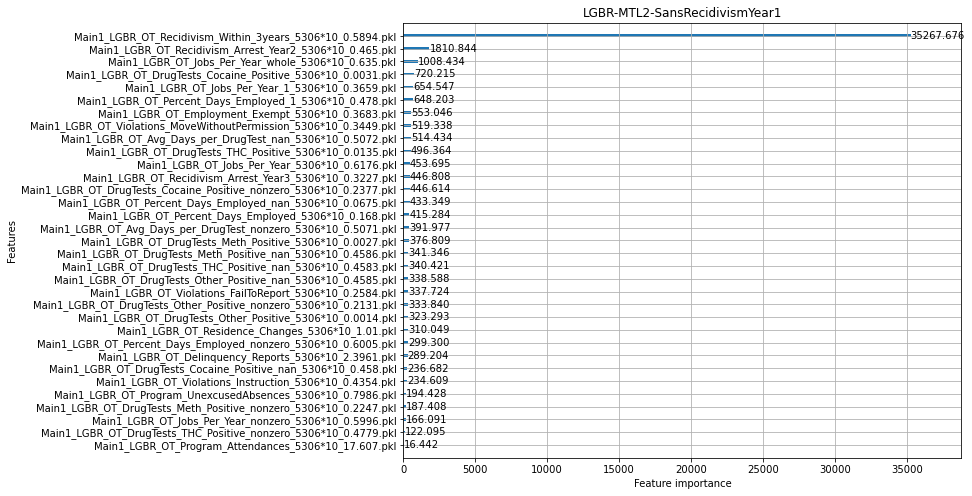

<Figure size 720x576 with 0 Axes>

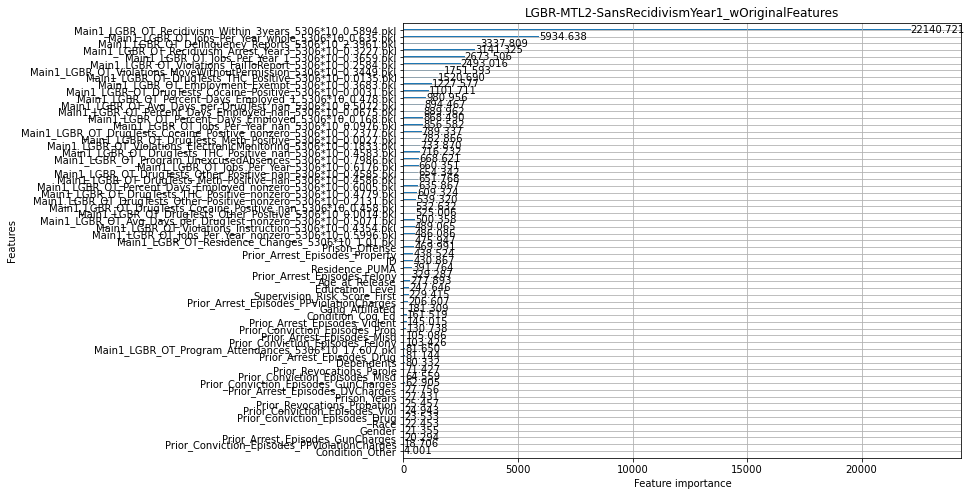

<Figure size 720x576 with 0 Axes>

In [124]:
%%time
for name, features in layer2_models.items():
    model = name; print(name); 
    r, final_score = fitModel(pd.concat( features, axis = 1),
                             y, lgb.LGBMClassifier(# objective = boundedMSE,
                                 n_jobs = 1), 
                            lgbr_params, 10, 
                         'neg_log_loss', 
                              StratifiedKFold(n_splits = random.randrange(5, 7), 
                                                     shuffle = True,
                                                random_state = datetime.datetime.now().microsecond),
                                                     verbose = 3,
                              feature_drop = 0.1
                                                     )
    lgb.plot_importance(r['models'][-1], importance_type = 'gain', title = name)
    plt.figure()
    pickle.dump(r, open('results/{}_{}_{}*{}_{}.pkl'.format(
                        LABEL, model, fold_seed, N_REPEATS, round(final_score, 4)), 'wb') )
    print(); print(); print()